In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from laplace_hdc_helper import load_dataset
from laplace_hdc_encoder import hdc_encoder
from laplace_hdc_classifier import train_hdc_classifier, test_hdc_classifier
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
from scipy.io import savemat, loadmat

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device:\t{device}")


Using device:	cuda:0


### Hyperparameters

In [2]:
hyperdim = 5000 
bandwidth_parameter = 3 # bandwidth parameter
encoder_mode = 'shift_1d'
classifier_mode="float_sgd"
epochs=10

## Load Data

In [4]:
class_names = np.array(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])

# load the MNIST training data
train_data = datasets.MNIST(
    '../../Data',
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

# Load the MNIST testing data
test_data = datasets.MNIST(
    '../../Data',
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

num_classes = len(class_names)
print(num_classes)

10


## Kernel Matrix Construction

lambda = 0.02335093729197979


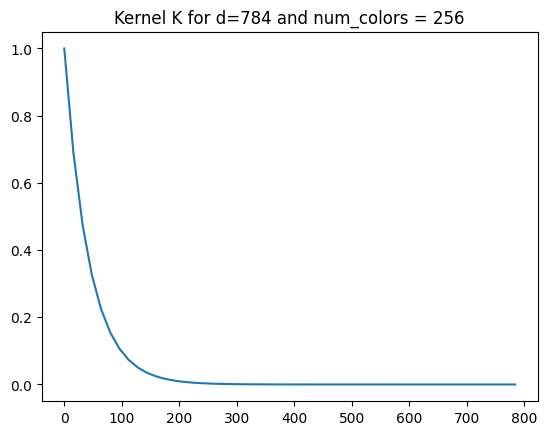

In [5]:
# Determining Lambda from random 1000 samples
batch_size = 1024
num_colors = 256

X,  _ = next(iter(DataLoader(train_data, batch_size=1000, shuffle=True)))
X = X.reshape(X.shape[0],-1)

D = torch.sum(torch.abs(X.unsqueeze(0)-X.unsqueeze(1)),dim=2)
a = torch.median(D.flatten())
lmd = bandwidth_parameter/a
print(f"lambda = {lmd}")

# Define the local kernel
x = np.linspace(0, 1, num=num_colors).reshape(-1, 1)
f = lambda X: 1 - lmd*X
kernel = f(np.abs(x - x.T))

# Visualize the global kernel
d = train_data[0][0].squeeze().numel()
S = lambda v: np.exp(-lmd*v)
v = np.linspace(0, d)
plt.plot(v, S(v))
plt.title(f"Kernel K for d={d} and num_colors = {num_colors}")
plt.show()

## Create Encoder

In [6]:
encoder = hdc_encoder(d, hyperdim, kernel, encoder_mode)
print(f"mode: {encoder_mode}\nHyperdimension: {encoder.hyperdim}")

mode: shift_1d
Hyperdimension: 5000


## Encode Data

In [7]:
batch_size = 128
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

# # Encode the data

# t0 = time.time()
# train_hdc = encoder.encode(train_loader)
# t1 = time.time()

# print(f"train encoding time: {t1 -t0}")

# t0 = time.time()
# test_hdc = encoder.encode(test_loader)
# t1 = time.time()

# print(f"test encoding time: {t1 -t0}")

## Classification

In [8]:
# batch_size = 1024
# train_loader_hdc = DataLoader(
#     train_hdc,
#     batch_size=batch_size,
#     shuffle=True,
# )

# test_loader_hdc = DataLoader(
#     test_hdc,
#     batch_size=batch_size,
#     shuffle=True,
# )

# model = train_hdc_classifier(train_loader_hdc, num_classes, mode=classifier_mode, epochs=epochs)
# accuracy = test_hdc_classifier(model, test_loader_hdc)
# print(f"mode: {classifier_mode} \ntest accuracy: {accuracy}")

In [10]:
hyperdims = loadmat('../EHDGNet_MNIST_nHD.mat')['EHDGNet_MNIST_nHD']
hyperdims = np.mean(hyperdims, axis=1, dtype=int)
hyperdims

array([ 5000,  6000,  7000,  8000,  9000, 10000, 11000, 11750, 12750,
       13750, 14750])

In [11]:
num_workers = 2
pin_memory=True
n_splits = 20
split_size = len(test_data) // n_splits
hyperdims = hyperdims
accuracies = np.zeros((len(hyperdims), n_splits))
for i, nHDC in enumerate(hyperdims):
    print(f'Hyperdimension: {nHDC} Started --------------')
    # Train
    encoder = hdc_encoder(d, nHDC, kernel, encoder_mode)
    train_hdc = encoder.encode(train_loader)
    train_loader_hdc = DataLoader(
        train_hdc,
        batch_size=750,
        shuffle=True,
        num_workers=0,      # <-- no background workers
        pin_memory=False    # <-- nothing to pin; data is on GPU
    )
    model = train_hdc_classifier(train_loader_hdc, num_classes, mode=classifier_mode, epochs=10)
    print(f'Encoding Train Data and Training the Model for nHDC={nHDC} finished')
    for split_idx in tqdm(range(n_splits)):
        # Test
        start_idx = split_idx * split_size
        end_idx = start_idx + split_size
        split_subset = Subset(test_data, range(start_idx, end_idx))
        split_loader = DataLoader(
            split_subset,
            batch_size=128,
            shuffle=False,
            num_workers=num_workers,   # 2, as you set above
            pin_memory=pin_memory      # True
        )
        split_hdc = encoder.encode(split_loader)
        split_loader_hdc = DataLoader(
            split_hdc,
            batch_size=128,
            shuffle=True,
            num_workers=0,
            pin_memory=False
        )
        accuracies[i, split_idx] = test_hdc_classifier(model, split_loader_hdc)
    print(f'Hyperdimension: {nHDC} Finished. Average Accuracy over 20 splits: {np.mean(accuracies[i])}')


Hyperdimension: 5000 Started --------------


100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


Encoding Train Data and Training the Model for nHDC=5000 finished


100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


Hyperdimension: 5000 Finished. Average Accuracy over 20 splits: 0.9571
Hyperdimension: 6000 Started --------------


100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


Encoding Train Data and Training the Model for nHDC=6000 finished


100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


Hyperdimension: 6000 Finished. Average Accuracy over 20 splits: 0.9602
Hyperdimension: 7000 Started --------------


100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


Encoding Train Data and Training the Model for nHDC=7000 finished


100%|██████████| 20/20 [00:09<00:00,  2.17it/s]


Hyperdimension: 7000 Finished. Average Accuracy over 20 splits: 0.9589000000000001
Hyperdimension: 8000 Started --------------


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Encoding Train Data and Training the Model for nHDC=8000 finished


100%|██████████| 20/20 [00:09<00:00,  2.10it/s]


Hyperdimension: 8000 Finished. Average Accuracy over 20 splits: 0.9575000000000001
Hyperdimension: 9000 Started --------------


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Encoding Train Data and Training the Model for nHDC=9000 finished


100%|██████████| 20/20 [00:10<00:00,  1.94it/s]


Hyperdimension: 9000 Finished. Average Accuracy over 20 splits: 0.9693999999999999
Hyperdimension: 10000 Started --------------


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


Encoding Train Data and Training the Model for nHDC=10000 finished


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Hyperdimension: 10000 Finished. Average Accuracy over 20 splits: 0.9577
Hyperdimension: 11000 Started --------------


100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


Encoding Train Data and Training the Model for nHDC=11000 finished


100%|██████████| 20/20 [00:11<00:00,  1.70it/s]


Hyperdimension: 11000 Finished. Average Accuracy over 20 splits: 0.9657000000000002
Hyperdimension: 11750 Started --------------


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


Encoding Train Data and Training the Model for nHDC=11750 finished


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Hyperdimension: 11750 Finished. Average Accuracy over 20 splits: 0.9668999999999999
Hyperdimension: 12750 Started --------------


100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


Encoding Train Data and Training the Model for nHDC=12750 finished


100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


Hyperdimension: 12750 Finished. Average Accuracy over 20 splits: 0.9669000000000001
Hyperdimension: 13750 Started --------------


100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


Encoding Train Data and Training the Model for nHDC=13750 finished


100%|██████████| 20/20 [00:13<00:00,  1.47it/s]


Hyperdimension: 13750 Finished. Average Accuracy over 20 splits: 0.9681
Hyperdimension: 14750 Started --------------


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


Encoding Train Data and Training the Model for nHDC=14750 finished


100%|██████████| 20/20 [00:14<00:00,  1.39it/s]

Hyperdimension: 14750 Finished. Average Accuracy over 20 splits: 0.9709


In [13]:
np.mean(accuracies*100, axis=1)

array([95.71, 96.02, 95.89, 95.75, 96.94, 95.77, 96.57, 96.69, 96.69,
       96.81, 97.09])

In [14]:
np.std(accuracies*100, axis=1)

array([2.09425404, 1.9543797 , 2.11326761, 2.07352357, 1.57873367,
       2.25146619, 1.83442089, 2.08564139, 1.9813884 , 1.84659145,
       1.59558767])

In [15]:
savemat('LaplaceHDC_MNIST.mat', {'LaplaceHDC_MNIST': accuracies*100})